# 자전거 대여 수요 예측

# 1. 개요

- 문제 정의:  
과거의 데이터에 기반해서 미래의 수요를 "예측"하는 작업이기에  
지도 학습의 선형 모델(LinearRegression, Lasso, Ridge)를 사용해야 한다.
- 손실 함수:  
Root Mean Squared Logarithmic Error

## 1.1. 준비물
- `train.csv`, `test.csv` 데이터
- 데이터셋 확인(전처리 필요)

## 1.2. 알아볼 속성
- 특정 시간대의 자전거 대여 패턴은 무엇인가?
- 날씨 변수와 자전거 대여 수요 간의 상관관계는 무엇인가?
- 계절별 자전거 대여 패턴의 차이는 무엇인가?
- 공휴일과 업무일의 자전거 수요 대여 수요 차이는 무엇인가?
- 온도, 습도, 바람세기 확인하기

## 1.3. 알아낼 것
- 자전거 대여 수요를 예측하기 위해 사용할 수 있는 가장 중요한 변수는 무엇인가?

## 1.5. 필요 과정
- 이상치 제거
- Feature Scaling
- one-hot encoding

## 1.6. 최종 목표
- 자전거 대여 수요 예측 모델을 구축하고, 이를 기반으로 한 운영 전략을 제안하기.

# 2. 데이터 준비

In [ ]:
!pip install koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 52.4 MB/s eta 0:00:00


In [ ]:
# 필요 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import root_mean_squared_error, mean_squared_log_error, root_mean_squared_log_error
from sklearn.model_selection import GridSearchCV

In [ ]:
# 파일 불러오기
train_path = "/content/drive/MyDrive/codeit/스프린트미션/data/train.csv"
test_path = "/content/drive/MyDrive/codeit/스프린트미션/data/test.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

In [ ]:
# 훈련 데이터셋 확인
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [ ]:
# 훈련 데이터셋 변수 확인: 결측치가 없음을 확인
print(train.info())
print('=' * 100)
print(train.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None
                   datetime        season       holiday    workingday  \
count                 10886  10886.000000  10886.000000  10886.000000   
unique                10886           NaN           NaN           NaN   
top     2012-12-19 23:00:00 

In [ ]:
# 날짜 데이터 변환
train['datetime'] = pd.to_datetime(train['datetime'])

train['datetime'].dtype

dtype('<M8[ns]')

In [ ]:
# 테스트 데이터셋 확인
test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


In [ ]:
# 테스트 데이터셋 변수 확인: 결측치가 없음을 확인
print(test.info())
print('=' * 100)
print(test.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB
None
                   datetime       season      holiday   workingday  \
count                  6493  6493.000000  6493.000000  6493.000000   
unique                 6493          NaN          NaN          NaN   
top     2012-12-31 23:00:00          NaN          NaN          NaN   
freq                      1          NaN          NaN          NaN   
mean                    

In [ ]:
# 날짜 데이터 변환
test['datetime'] = pd.to_datetime(test['datetime'])

test['datetime'].dtype

dtype('<M8[ns]')

# 3. 데이터 분석

## 3.1. 특정 시간대의 자전거 대여 패턴

In [ ]:
# 시간대 데이터 확인
train['datetime'].head()

,datetime
0,2011-01-01 00:00:00
1,2011-01-01 01:00:00
2,2011-01-01 02:00:00
3,2011-01-01 03:00:00
4,2011-01-01 04:00:00


In [ ]:
# 시간 데이터 분할(년, 월, 일, 시간, 요일까지만)

train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
# 월(0) 화(1) 수(2) 목(3) 금(4) 토(5) 일(6)
train['dayofweek'] = train['datetime'].dt.dayofweek

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek

train[['year', 'month', 'day', 'hour', 'dayofweek']].head()


,year,month,day,hour,dayofweek
0,2011,1,1,0,5
1,2011,1,1,1,5
2,2011,1,1,2,5
3,2011,1,1,3,5
4,2011,1,1,4,5


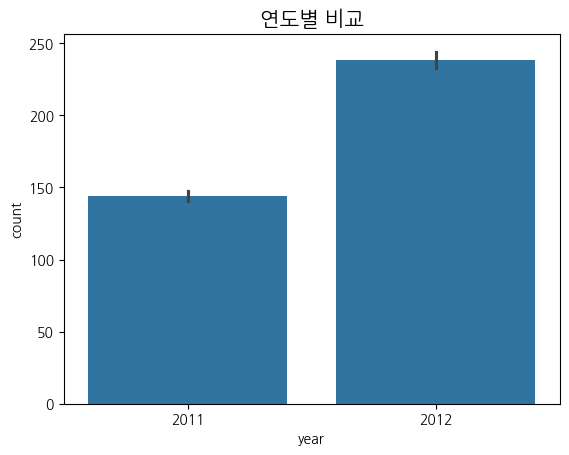

In [ ]:
# 간단하게만 그래프화
sns.barplot(train, x='year', y='count')
plt.title('연도별 비교', fontsize=15)
plt.show()

2012년도의 이용 비율이 많다.

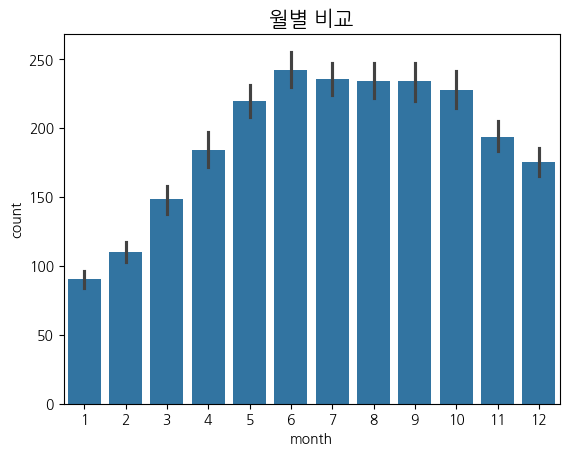

In [ ]:
sns.barplot(train, x='month', y='count')
plt.title('월별 비교', fontsize=15)
plt.show()

6, 7, 8월에 이용량이 제일 많다.

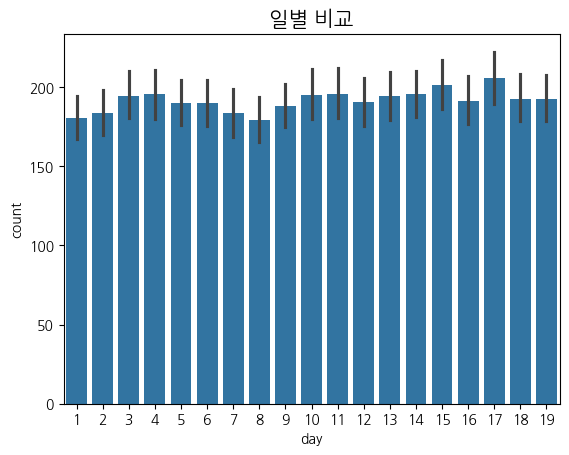

In [ ]:
sns.barplot(train, x='day', y='count')
plt.title('일별 비교', fontsize=15)
plt.show()

일별 비교는 어떤 경향을 확인하기 어렵다.

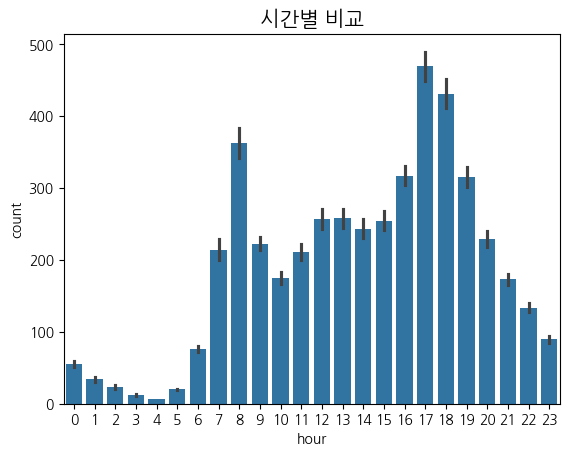

In [ ]:
sns.barplot(train, x='hour', y='count')
plt.title('시간별 비교', fontsize=15)
plt.show()

8시(출근 시간)이나 17시(퇴근 시간)에 가장 많이 이용되는 것을 알 수 있다.

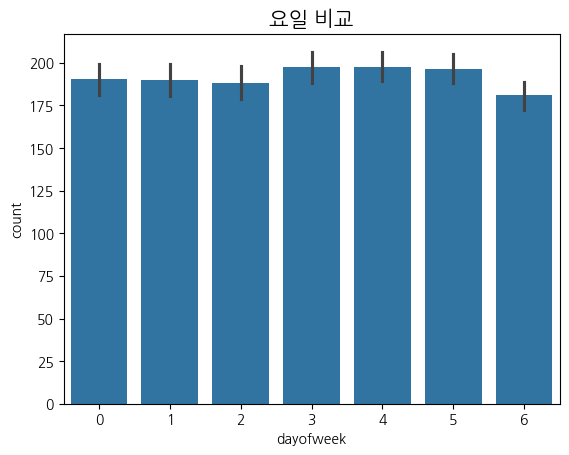

In [ ]:
sns.barplot(train, x='dayofweek', y = 'count')
plt.title('요일 비교', fontsize=15)
plt.show()

요일별 피교에서는 큰 차이를 확인할 수 없었다.

## 3.2. 날씨 변수와 자전거 대여 수요 간의 상관관계는 무엇인가?

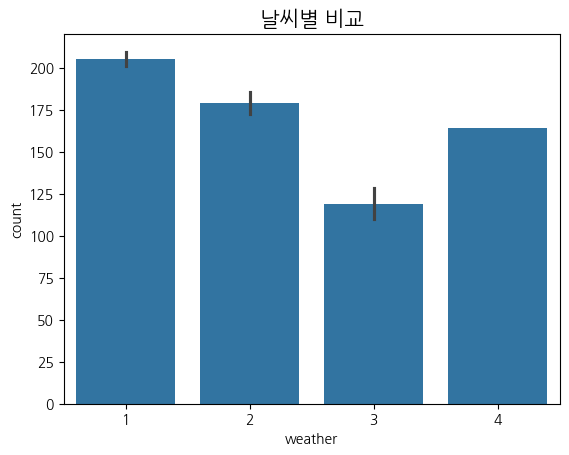

In [ ]:
# 1: 맑음, 2: 구름낌/안개, 3: 약간의 비/눈, 4: 폭우/폭설
sns.barplot(train, x='weather', y='count')
plt.title('날씨별 비교', fontsize=15)
plt.show()

맑음에서 가장 높은 수요를 보이지만, 이상하게도 폭우/폭설에도 높은 수치를 보인다.

## 3.3. 계절별 자전거 대여 패턴의 차이는 무엇인가?

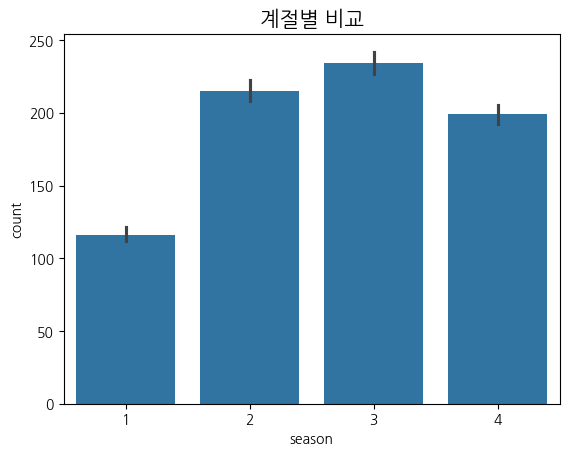

In [ ]:
# 1: 봄, 2: 여름, 3: 가을, 4: 겨울
sns.barplot(train, x='season', y='count')
plt.title('계절별 비교', fontsize=15)
plt.show()

여름과 가을에 가장 이용률이 높다.

## 3.4. 공휴일과 업무일의 자전거 수요 대여 수요 차이는 무엇인가?


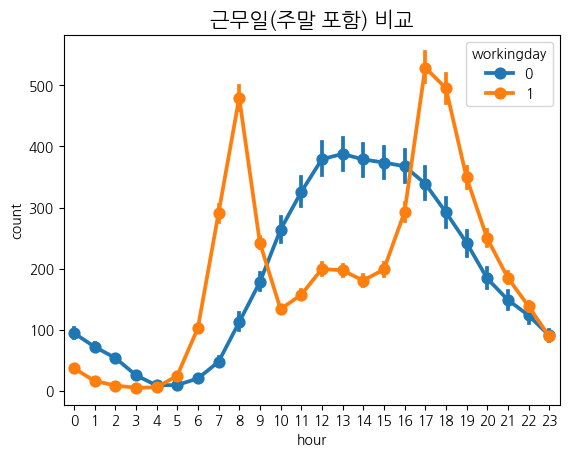

In [ ]:
# 근무일 여부 (0: 주말/공휴일, 1: 근무일)
sns.pointplot(data=train, x='hour', y='count', hue='workingday')
plt.title('근무일(주말 포함) 비교', fontsize=15)
plt.show()

예상대로 그무일의 경우 출퇴근 시간이 많다.

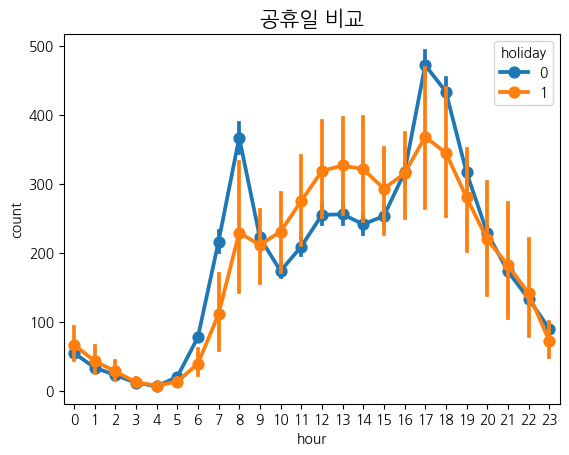

In [ ]:
# 공휴일 여부 (0: 평일, 1: 공휴일)
sns.pointplot(data=train, x='hour', y='count', hue='holiday')
plt.title('공휴일 비교', fontsize=15)
plt.show()

큰 차이는 보이지 않지만, 출퇴근에 초첨을 맞춘 주말 포함 workday 컬럼을 사용한다.

## 3.5. 상관관계 확인하기

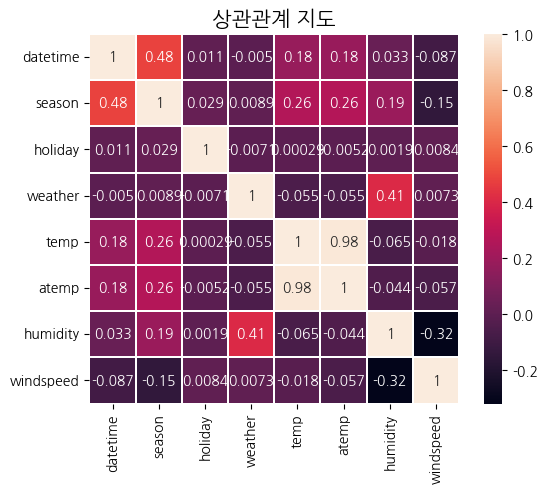

In [ ]:
corr_data = train[['datetime', 'season', 'holiday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']]
sns.heatmap(corr_data.corr(), linewidths = 0.1, square = True, annot = True)
plt.title('상관관계 지도', fontsize=15)
plt.show()

temp(실측 온도)와 atemp(체감 온도)의 상관관계도가 매우 높다. 따라서 실측 온도 temp만 사용한다.

## 3.6. 온도, 습도, 바람세기 확인하기

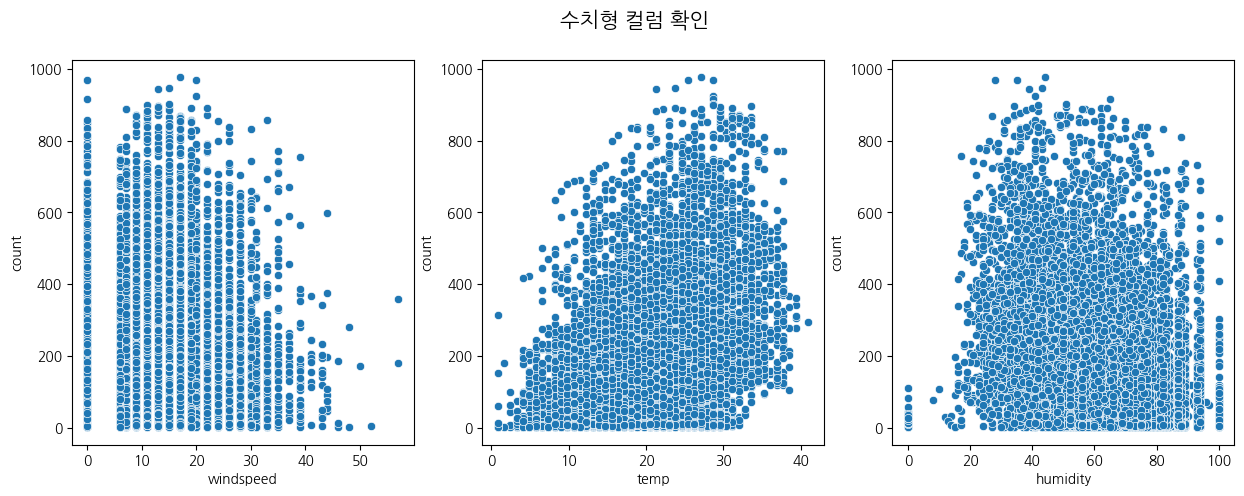

In [ ]:
# plt.subplot으로 여러 그래프 만들고, ncol(열 개수) 3개로 설정하기
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize=(15,5))

sns.scatterplot(data = train, x = 'windspeed', y = 'count', ax = ax1)
sns.scatterplot(data = train, x = 'temp', y = 'count', ax = ax2)
sns.scatterplot(data = train, x = 'humidity', y =  'count', ax = ax3)
plt.suptitle('수치형 컬럼 확인', fontsize=15)
plt.show()

In [ ]:
len(train[train['windspeed']==0])

1313

In [ ]:
len(train[train['temp']==0])

0

In [ ]:
len(train[train['humidity']==0])

22

windspeed, humidity가 0인 데이터가 보인다. 이에 대한 처리가 필요해 보인다.

# 4. 데이터 전처리

## 4.1. 이상치 제거하기

<Axes: xlabel='count'>

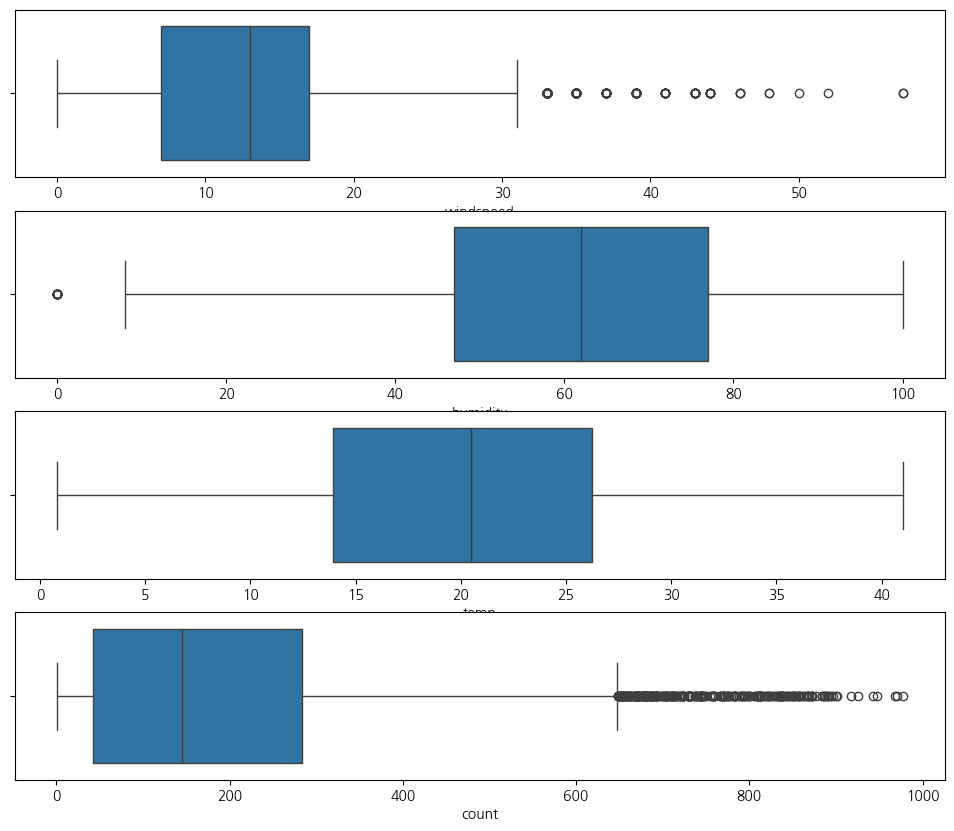

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (12,10))
sns.boxplot(data = train, x = 'windspeed', ax = ax1)
sns.boxplot(data = train, x = 'humidity', ax = ax2)
sns.boxplot(data = train, x = 'temp', ax = ax3)
sns.boxplot(data = train, x = 'count', ax = ax4)

평균적인 수요를 확인하기 위해 y 값에 해당하는 컬럼의 이상치도 제거한다.  
다만, 테스트 파일에 대해서는 수정하지 않는다.

In [ ]:
# 이상치 탐지 및 인덱스 리스트 반환 함수 만들기
def outlier_detector(data, col):
    # Q1, Q3, IQR 계산
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    # 이상치 기준
    outlier_step = 1.5 * IQR

    # 이상치 인덱스 추출
    outlier_index = data[(data[col] < Q1 - outlier_step) | (data[col] > Q3 + outlier_step)].index.tolist()

    return outlier_index

In [ ]:
# 원래 데이터 모양
train.shape

(10886, 17)

In [ ]:
# windspeed 이상치 탐지

wo = outlier_detector(train, 'windspeed')
print(len(wo))

227


In [ ]:
# windspeed 이상치 제거

train = train.drop(wo, axis=0)
train.shape

(10659, 17)

In [ ]:
# humidity 이상치 탐지

ho = outlier_detector(train, 'humidity')
print(len(ho))

21


In [ ]:
# humidity 이상치 제거

train = train.drop(ho, axis=0)
train.shape

(10638, 17)

In [ ]:
# count 이상치 탐지

co = outlier_detector(train, 'count')
print(len(co))

286


In [ ]:
# count 이상치 제거

train = train.drop(co, axis=0)
train.shape

(10352, 17)

<Axes: xlabel='count', ylabel='Count'>

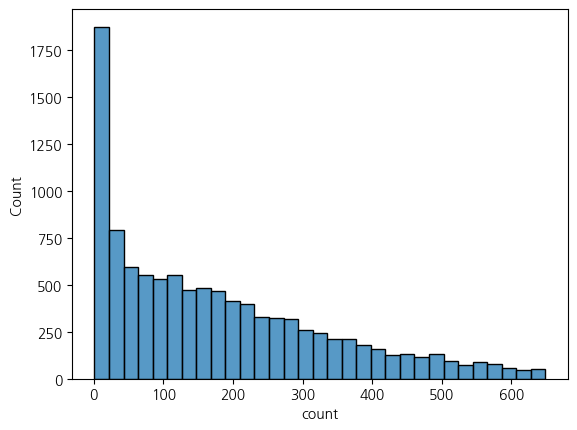

In [ ]:
sns.histplot(train['count'])

여전히 count에 왜곡이 있다.

<Axes: xlabel='count', ylabel='Count'>

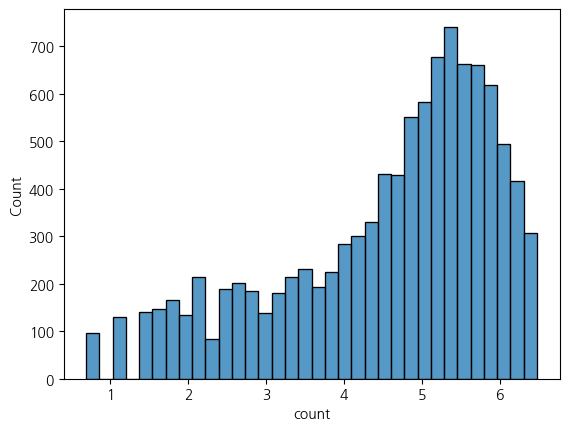

In [ ]:
#자연로그(log)로 변환하여, 값의 범위를 줄이고 정규분포에 가깝게 만들기
#추후 모델로 test의 count 계산 시 np.expm1() 적용 필요
train['count'] = np.log1p(train['count'])
sns.histplot(train['count'])

In [ ]:
train.shape

(10352, 17)

최종 데이터 사이즈는 10352 x 17

## 4.2. 훈련 데이터 정제
- train 데이터의 다항다중 선형회귀를 위한 처리
- test 데이터의 다항다중 선형회귀를 위한 처리

In [ ]:
# 훈련 데이터 준비(drop할 컬럼 선별)
train = train.drop(['datetime', 'atemp', 'year', 'day', 'holiday', 'casual', 'registered'], axis = 1)
temp_test = test.drop(['datetime', 'atemp', 'year', 'day', 'holiday'], axis = 1)

In [ ]:
train.columns

Index(['season', 'workingday', 'weather', 'temp', 'humidity', 'windspeed',
       'count', 'month', 'hour', 'dayofweek'],
      dtype='object')

In [ ]:
# train: 훈련 데이터 준비(train 데이터 분할)
we_x = train.drop(columns='count', axis=1)
we_y = train[['count']]

we_x.columns


Index(['season', 'workingday', 'weather', 'temp', 'humidity', 'windspeed',
       'month', 'hour', 'dayofweek'],
      dtype='object')

In [ ]:
# train 데이터셋 내 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(we_x, we_y, test_size=0.2, random_state=42)

In [ ]:
# 상호작용 속성(PolynomialFeatures)을 만들고 싶은 특성 리스트
poly_features = ['temp', 'humidity', 'windspeed']

# 나머지 특성 리스트
other_features = ['weather', 'season', 'workingday', 'month', 'hour', 'dayofweek']

# ColumnTransformer 정의
polyfeatures_processor = ColumnTransformer(
    transformers=[
        # PolynomialFeatures 적용
        ('poly',
         PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
         poly_features),

        # 나머지 특성은 그대로 통과
        ('pass', 'passthrough', other_features)
    ],
    remainder='passthrough'
)

# 데이터에 fit_transform 적용
poly_processed_np = polyfeatures_processor.fit_transform(x_train)

# 데이터 누수에 주의하며 x_test와 test도 변환
xtest_poly_processed_np = polyfeatures_processor.transform(x_test)
realtest_poly_processed_np = polyfeatures_processor.transform(temp_test)

# ColumnTransformer에서 생성된 최종 열 이름 가져오기
# ColumnTransformer의 get_feature_names_out()을 사용
feature_names = polyfeatures_processor.get_feature_names_out()

# 3. Numpy 배열을 Pandas DataFrame으로 변환하며 열 이름 지정
# 인덱스는 원본 we_x의 인덱스를 사용
x_train__poly = pd.DataFrame(
    poly_processed_np,
    columns=feature_names,
    index=x_train.index
)

x_test__poly = pd.DataFrame(
    xtest_poly_processed_np,
    columns=feature_names,
    index=x_test.index
)

test__poly = pd.DataFrame(
    realtest_poly_processed_np,
    columns=feature_names,
    index=temp_test.index
)

# 결과를 원본 변수에 덮어쓰기
x_train = x_train__poly
x_test = x_test__poly
temp_test = test__poly

print(x_train.columns)
print(f"최종 특성 개수: {x_train.shape[1]}")

Index(['poly__temp', 'poly__humidity', 'poly__windspeed',
       'poly__temp humidity', 'poly__temp windspeed',
       'poly__humidity windspeed', 'pass__weather', 'pass__season',
       'pass__workingday', 'pass__month', 'pass__hour', 'pass__dayofweek'],
      dtype='object')
최종 특성 개수: 12


In [ ]:
x_train.columns = ['temp', 'humidity', 'windspeed',
       'temp humidity', 'temp windspeed',
       'humidity windspeed',
       'weather', 'season', 'workingday', 'month',
       'hour', 'dayofweek']

In [ ]:
x_test.columns = ['temp', 'humidity', 'windspeed',
       'temp humidity', 'temp windspeed',
       'humidity windspeed', 'weather', 'season',
       'workingday', 'month', 'hour', 'dayofweek']

In [ ]:
temp_test.columns = ['temp', 'humidity', 'windspeed',
       'temp humidity', 'temp windspeed',
       'humidity windspeed', 'weather', 'season',
       'workingday', 'month', 'hour', 'dayofweek']

## 4.3. Feature Scaling

- 스켈링 작업 필요 컬럼:  
'temp', 'humidity', 'windspeed', 'temp humidity', 'temp windspeed', 'humidity windspeed', 'temp humidity windspeed'
- **StandardScaling** 사용

In [ ]:
standardization = StandardScaler()
x_train[['temp', 'humidity', 'windspeed', 'temp humidity', 'temp windspeed', 'humidity windspeed']] = standardization.fit_transform(x_train[['temp', 'humidity', 'windspeed', 'temp humidity', 'temp windspeed', 'humidity windspeed']])

x_train[['temp', 'humidity', 'windspeed', 'temp humidity', 'temp windspeed', 'humidity windspeed']].head()

,temp,humidity,windspeed,temp humidity,temp windspeed,humidity windspeed
8113,0.255600,1.349944,-0.708474,1.193431,-0.502436,-0.235812
6288,-1.318100,0.396539,-1.649822,-0.959062,-1.350993,-1.587900
9724,0.045774,0.237638,-0.440032,0.211076,-0.341236,-0.264909
7911,0.885080,0.343572,-0.708474,1.054697,-0.313868,-0.527740
10016,-0.583706,-1.192469,1.308442,-1.071171,0.525546,0.343486


In [ ]:
# 데이터 누수에 주의해서 변환
x_test[['temp', 'humidity', 'windspeed', 'temp humidity', 'temp windspeed', 'humidity windspeed']] = standardization.transform(x_test[['temp', 'humidity', 'windspeed', 'temp humidity', 'temp windspeed', 'humidity windspeed']])

x_test[['temp', 'humidity', 'windspeed', 'temp humidity', 'temp windspeed', 'humidity windspeed']].head()

,temp,humidity,windspeed,temp humidity,temp windspeed,humidity windspeed
554,-1.213186,-0.133131,0.367094,-1.043143,-0.475610,0.387301
5006,-0.373880,-1.139503,-0.842695,-0.929633,-0.785108,-1.047771
10039,-0.688620,-0.874668,1.308442,-0.975878,0.426781,0.633195
6173,-1.423013,-1.351370,0.097752,-1.565852,-0.709200,-0.532519
4177,-0.164053,0.237638,0.097752,0.023294,-0.009061,0.323196


In [ ]:
x_test.columns

Index(['temp', 'humidity', 'windspeed', 'temp humidity', 'temp windspeed',
       'humidity windspeed', 'weather', 'season', 'workingday', 'month',
       'hour', 'dayofweek'],
      dtype='object')

In [ ]:
x_train.columns

Index(['temp', 'humidity', 'windspeed', 'temp humidity', 'temp windspeed',
       'humidity windspeed', 'weather', 'season', 'workingday', 'month',
       'hour', 'dayofweek'],
      dtype='object')

In [ ]:
# 데이터 누수에 주의해서 변환
temp_test[['temp', 'humidity', 'windspeed', 'temp humidity', 'temp windspeed', 'humidity windspeed']] = standardization.transform(temp_test[['temp', 'humidity', 'windspeed', 'temp humidity', 'temp windspeed', 'humidity windspeed']])

temp_test[['temp', 'humidity', 'windspeed', 'temp humidity', 'temp windspeed', 'humidity windspeed']].head()

,temp,humidity,windspeed,temp humidity,temp windspeed,humidity windspeed
0,-1.213186,-0.344998,1.846226,-1.116014,0.166364,1.607592
1,-1.213186,-0.344998,-1.649822,-1.116014,-1.350993,-1.587900
2,-1.213186,-0.344998,-1.649822,-1.116014,-1.350993,-1.587900
3,-1.213186,-0.344998,-0.170690,-1.116014,-0.709019,-0.235930
4,-1.213186,-0.344998,-0.170690,-1.116014,-0.709019,-0.235930


## 4.2. one-hot encoding 범주형 변수 처리

- `weather`, `season`, `workday` 컬럼에 one-hot encoding 수행
- workingday  0: 주말/공휴일, 1: 근무일
- weather 1: 맑음, 2: 구름낌/안개, 3: 약간의 비/눈, 4: 폭우/폭설
- season	1: 봄, 2: 여름, 3: 가을, 4: 겨울
- 범주형을 처리하는 과정에서 열을 새로 만들기 때문에, 이 경우에는 test 파일에도 수행한다.

In [ ]:
x_train = pd.get_dummies(x_train, columns = ['weather'])
x_test = pd.get_dummies(x_test, columns = ['weather'])
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)
temp_test = pd.get_dummies(temp_test, columns = ['weather'])

x_train = pd.get_dummies(x_train, columns = ['season'])
x_test = pd.get_dummies(x_test, columns = ['season'])
temp_test = pd.get_dummies(temp_test, columns = ['season'])

x_train = pd.get_dummies(x_train, columns = ['workingday'])
x_test = pd.get_dummies(x_test, columns = ['workingday'])
temp_test = pd.get_dummies(temp_test, columns = ['workingday'])

In [ ]:
x_train.columns

Index(['temp', 'humidity', 'windspeed', 'temp humidity', 'temp windspeed',
       'humidity windspeed', 'month', 'hour', 'dayofweek', 'weather_1.0',
       'weather_2.0', 'weather_3.0', 'weather_4.0', 'season_1.0', 'season_2.0',
       'season_3.0', 'season_4.0', 'workingday_0.0', 'workingday_1.0'],
      dtype='object')

In [ ]:
x_train.describe(include='all')

,temp,humidity,windspeed,temp humidity,temp windspeed,humidity windspeed,month,hour,dayofweek,weather_1.0,weather_2.0,weather_3.0,weather_4.0,season_1.0,season_2.0,season_3.0,season_4.0,workingday_0.0,workingday_1.0
count,8.281000e+03,8.281000e+03,8.281000e+03,8.281000e+03,8.281000e+03,8.281000e+03,8281.000000,8281.000000,8281.000000,8281,8281,8281,8281,8281,8281,8281,8281,8281,8281
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,True
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5457,6099,7640,8280,6252,6199,6211,6181,5582,5582
mean,-1.097760e-14,-1.756836e-16,-2.560981e-14,-8.715324e-15,-1.844952e-14,7.304010e-15,6.537012,11.424103,3.033088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.000060e+00,1.000060e+00,1.000060e+00,1.000060e+00,1.000060e+00,1.000060e+00,3.452838,6.986828,2.015488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-2.472146e+00,-2.887412e+00,-1.649822e+00,-2.088560e+00,-1.350993e+00,-1.587900e+00,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,-7.935329e-01,-7.687339e-01,-7.084741e-01,-8.749798e-01,-7.091998e-01,-5.998584e-01,4.000000,5.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4.577368e-02,-2.719665e-02,-1.706899e-01,-6.359083e-02,-1.567280e-01,-9.107558e-02,7.000000,11.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7.801670e-01,8.202745e-01,6.355359e-01,7.786281e-01,5.743875e-01,5.799108e-01,10.000000,18.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 5. 모델링 (Ridge)

모델 선정 이유:
- 모든 변수가 조금씩 영향을 준다고 판단하여 Lasso보다는 안정적인 Ridge 사용 결정

## 5.1. GridSearchCV로 하이퍼파라미터 탐색 및 cross_val_score로 성능 평가



In [ ]:
# 파리미터 후보군
param_grid = {'alpha': [0.01, 0.1, 1, 10], 'solver': ['auto', 'sag']}

# 그리드 서치 설정
# GridSearchCV의 scoring은 단순히 하이퍼파라미터 튜닝용이므로, RMSLE일 필요는 없다.
grid = GridSearchCV(
    Ridge(),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error')

# 훈련
grid.fit(x_train, y_train)

# 결과 출력
print("최적 파라미터:", grid.best_params_)
print("최적 모델:", grid.best_estimator_)
print("최적 점수 (mse):", -grid.best_score_) # 음수이므로 부호 바꿔줌


최적 파라미터: {'alpha': 10, 'solver': 'sag'}
최적 모델: Ridge(alpha=10, solver='sag')
최적 점수 (mse): 1.0232874111904282


In [ ]:
# 예측
y_pred = grid.best_estimator_.predict(x_test)

In [ ]:
# RMSLE, RMSE 계산을 위한 변형 적용
rmse = root_mean_squared_error(y_test, y_pred)
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))


print("최적 파라미터:", grid.best_params_)
print(f"RMSE: {rmse: .4f}")
print(f"RMSLE: {rmsle:.4f}")

최적 파라미터: {'alpha': 10, 'solver': 'sag'}
RMSE:  1.0158
RMSLE: 0.2304


In [ ]:
# k-fold 교차 검증 수행
scores = cross_val_score(grid.best_estimator_, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("교차검증 평균 점수:", np.mean(-scores))

교차검증 평균 점수: 1.0232888052248854


## 5.2. 변수 해석

In [ ]:
# 변수 중요도 확인
pd.Series(grid.best_estimator_.coef_,index=x_train.columns).sort_values()

,0
season_3.0,-0.284848
humidity,-0.275671
weather_3.0,-0.176212
weather_1.0,-0.065478
windspeed,-0.058432
temp humidity,-0.047053
workingday_1.0,-0.025813
dayofweek,0.024018
workingday_0.0,0.025813
humidity windspeed,0.039873


- 온도가 높을수록 대여량이 급증. 날씨가 따뜻하면 자전거 이용이 늘어난다.
- 시간이 증가할수록(즉, 하루가 진행될수록) 대여 수요 증가. 출퇴근 시간의 영향이 크다.
- 바람이 강할수록 자전거 이용이 줄어든다.

### 운영 전략

- 봄, 여름 같은 온도가 높은 시기를 공략하여 이벤트 진행
- 공휴일, 주말을 공략하여 이벤트 진행

# 6. TEST 데이터 예측

In [ ]:
test_predict = grid.best_estimator_.predict(temp_test)

In [ ]:
test_predict = np.expm1(test_predict).round()
test_predict

array([ 15.,  16.,  17., ..., 187., 218., 210.])

In [ ]:
test['count'] = test_predict
test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek,count
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,3,15.0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,3,16.0
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,3,17.0
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3,19.0
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,3,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,19,0,188.0
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,20,0,206.0
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,2012,12,31,21,0,187.0
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,2012,12,31,22,0,218.0


In [ ]:
test.to_csv('test.csv', index=False)